In [2]:
# ===============================
# Random Forest on Credit Default Dataset
# ===============================

import pandas as pd
import numbers as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [3]:
# 1. Load dataset
data = pd.read_csv("UCI_Credit_Card.csv")
print(data.head())

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0   

In [4]:
# -----------------------------
# 2. Feature Engineering
# -----------------------------

# Credit Utilization (last month's bill / credit limit)
data["credit_utilization"] = data["BILL_AMT1"] / (data["LIMIT_BAL"] + 1)

# Payment Ratio (last payment / last bill)
data["payment_ratio"] = data["PAY_AMT1"] / (data["BILL_AMT1"] + 1)

# Average Payment Ratio (over 6 months)
bill_cols = ["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]
pay_cols  = ["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]
data["avg_payment_ratio"] = (data[pay_cols].sum(axis=1)) / (data[bill_cols].sum(axis=1) + 1)

# Total Bill & Payment
data["total_bill_amt"] = data[bill_cols].sum(axis=1)
data["total_pay_amt"]  = data[pay_cols].sum(axis=1)

# Payment to Credit Limit Ratio
data["payment_to_limit"] = data["total_pay_amt"] / (data["LIMIT_BAL"] + 1)

# Missed Payments Count
pay_status_cols = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
data["missed_payments"] = (data[pay_status_cols] > 0).sum(axis=1)

# Age Group (categorical binning → convert to numeric codes for ML)
data["age_group"] = pd.cut(data["AGE"], bins=[20,30,40,50,60,70,100],
                           labels=["20s","30s","40s","50s","60s","70+"])
data["age_group"] = data["age_group"].cat.codes  # convert categories to numbers

In [9]:
# 3. Feature-target split
X = data.drop("default.payment.next.month", axis=1)
y = data["default.payment.next.month"]


In [10]:
# -----------------------------
# 3. Prepare Features & Target
# -----------------------------
X = data.drop("default.payment.next.month", axis=1)
y = data["default.payment.next.month"]


In [11]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# -----------------------------
# Clean data before training
# -----------------------------
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [17]:
# -----------------------------
# 7. Evaluation
# -----------------------------

# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", auc)


Confusion Matrix:
[[6616  424]
 [1233  727]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7040
           1       0.63      0.37      0.47      1960

    accuracy                           0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

ROC-AUC Score: 0.7650627971358999


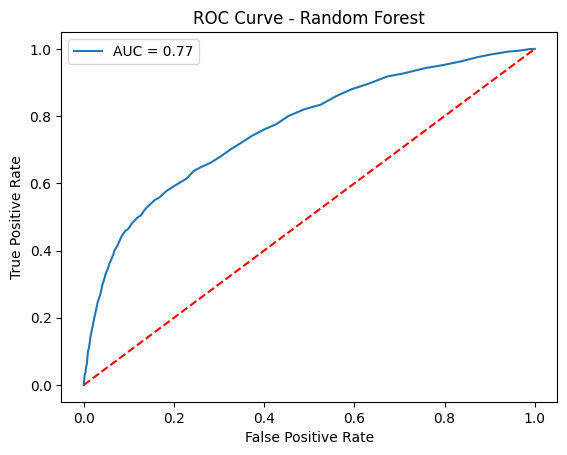

In [18]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()
